<a href="https://colab.research.google.com/github/marinba2200/DL_test/blob/main/1230_TF2_0_GAN_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries and load data

In [ ]:
# Import libraries
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [ ]:
# Load in the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# map inputs to (-1, +1) for better training #要讓照片介於+-1之，因後面用到tanh
x_train, x_test = x_train / 255 * 2 - 1, x_test / 255 * 2 - 1 # x_train, x_test = x_train / ??? * ??? - ???, x_test / ??? * ??? - ???
print("x_train.shape:", x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
x_train.shape: (60000, 28, 28)


## Data preprocessing

In [ ]:
# Flatten the data
N, H, W = x_train.shape
D = H * W # The input of discriminator # D = ??? * ??? D的input量=一張照片的長*寬
x_train = x_train.reshape(-1, D) # 一張圖變一長條 攤平
x_test = x_test.reshape(-1, D)

In [ ]:
# Dimensionality of the latent space
latent_dim = 100 # The input of generator

## Build the models

In [ ]:
# Get the generator model
def build_generator(latent_dim): #建立產生器函數，輸出影像大小要跟輸入影像大小一致
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)  #先對data做batch，再做標準化
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model
  
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization

In [ ]:
# Get the discriminator model
def build_discriminator(img_size):  #建立判斷器函數，輸出為二元(0,1)，判斷是否是假照片
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)

  model = Model(i, x)
  return model

## Compile the two models

Why do the first compile have metrics but the second have not?

In [ ]:
# Compile both models in preparation for training

# Build and compile the discriminator
discriminator = build_discriminator(D) # discriminator = ???(D)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])  # ???.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy']) 
# Why do the first compile have metrics but the second have not? 因為上面的discriminator是監督式學習，generator為非監督式學習
#監督式學習，有解答，所以有metrics
# ==========================================================================================================
# Build and compile the combined model
generator = build_generator(latent_dim) # generator = ???(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False # ???.trainable = False
#固定住判斷器

# The true output is fake, but we label them real!
fake_pred = discriminator(img) # fake_pred = ???(img) #建立假的預測結果

# Create the combined model object
combined_model = Model(z, fake_pred) #建立合併用的模型

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))  # ???.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5)) 
#非監督式學習

## The parameters and function we will need

In [ ]:
# Config
batch_size = 32
epochs = 30000
sample_period = 200 # every `sample_period` steps generate and save some data


# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [ ]:
# A function to generate a grid of random samples from the generator and save them to a file
def sample_images(epoch): #將訓練過程中產生的第epoch張圖片做保存
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch) #將訓練過程中產生的圖片每epoch(200)保存一張
  plt.close()

## Train the GAN

In [ ]:
# Main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  
  # Select a random batch of images #抓真照片出來
  idx = np.random.randint(0, x_train.shape[0], batch_size) # numpy.random.randint(low, high=None, size=None, dtype='l')
  real_imgs = x_train[idx]
  
  # Generate fake images #作假照片
  noise = np.random.randn(batch_size, latent_dim) # numpy.random.randn(d0, d1, ..., dn) # noise噪音
  fake_imgs = generator.predict(noise) # fake_imgs = ???.predict(noise)
  
  # Train the discriminator
  # both loss and accuracy are returned 
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones) # d_loss_real, d_acc_real = ???.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros) # d_loss_fake, d_acc_fake = ???.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  
  #######################
  ### Train generator ### #產生器的訓練用combined_model做
  #######################
  
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones) # g_loss = ???.train_on_batch(noise, ones)
  
  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones) # g_loss = ???.train_on_batch(noise, ones) 多跑一次，因為他只有noise卻要跑整張圖出來
  
  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_acc: {d_acc:.2f}, d_loss: {d_loss:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0: #每兩百張存一次
    sample_images(epoch)


epoch: 1/30000, d_acc: 0.52, d_loss: 0.50, g_loss: 0.34
epoch: 101/30000, d_acc: 0.83, d_loss: 0.47, g_loss: 3.32
epoch: 201/30000, d_acc: 0.64, d_loss: 0.66, g_loss: 1.07
epoch: 301/30000, d_acc: 0.42, d_loss: 0.76, g_loss: 0.59
epoch: 401/30000, d_acc: 0.48, d_loss: 0.71, g_loss: 0.63
epoch: 501/30000, d_acc: 0.48, d_loss: 0.70, g_loss: 0.66
epoch: 601/30000, d_acc: 0.47, d_loss: 0.69, g_loss: 0.66
epoch: 701/30000, d_acc: 0.47, d_loss: 0.69, g_loss: 0.68
epoch: 801/30000, d_acc: 0.50, d_loss: 0.68, g_loss: 0.70
epoch: 901/30000, d_acc: 0.56, d_loss: 0.64, g_loss: 0.73
epoch: 1001/30000, d_acc: 0.56, d_loss: 0.66, g_loss: 0.72
epoch: 1101/30000, d_acc: 0.62, d_loss: 0.64, g_loss: 0.73
epoch: 1201/30000, d_acc: 0.59, d_loss: 0.66, g_loss: 0.75
epoch: 1301/30000, d_acc: 0.80, d_loss: 0.62, g_loss: 0.77
epoch: 1401/30000, d_acc: 0.50, d_loss: 0.70, g_loss: 0.78
epoch: 1501/30000, d_acc: 0.58, d_loss: 0.68, g_loss: 0.79
epoch: 1601/30000, d_acc: 0.56, d_loss: 0.67, g_loss: 0.70
epoch: 17

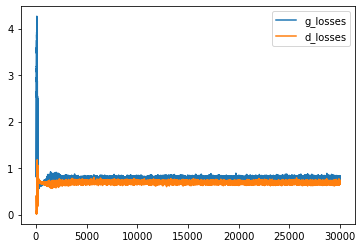

In [ ]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

## Check the results

In [ ]:
!ls gan_images

0.png	   13800.png  17800.png  21600.png  25600.png  29600.png  6600.png
10000.png  14000.png  18000.png  21800.png  25800.png  29800.png  6800.png
1000.png   1400.png   1800.png	 22000.png  26000.png  3000.png   7000.png
10200.png  14200.png  18200.png  2200.png   2600.png   3200.png   7200.png
10400.png  14400.png  18400.png  22200.png  26200.png  3400.png   7400.png
10600.png  14600.png  18600.png  22400.png  26400.png  3600.png   7600.png
10800.png  14800.png  18800.png  22600.png  26600.png  3800.png   7800.png
11000.png  15000.png  19000.png  22800.png  26800.png  4000.png   8000.png
11200.png  15200.png  19200.png  23000.png  27000.png  400.png	  800.png
11400.png  15400.png  19400.png  23200.png  27200.png  4200.png   8200.png
11600.png  15600.png  19600.png  23400.png  27400.png  4400.png   8400.png
11800.png  15800.png  19800.png  23600.png  27600.png  4600.png   8600.png
12000.png  16000.png  20000.png  23800.png  27800.png  4800.png   8800.png
1200.png   1600.png   2000.png

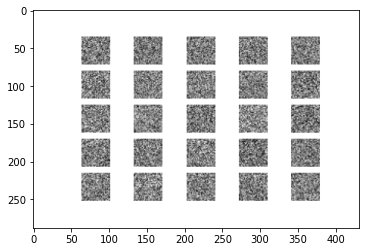

In [ ]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

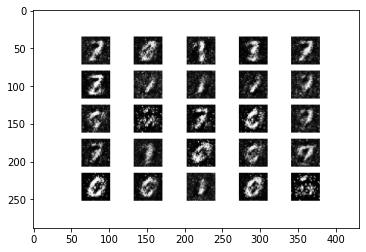

In [ ]:
a = imread('gan_images/1000.png')
plt.imshow(a)

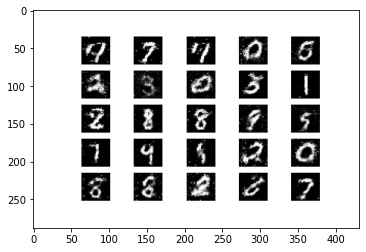

In [ ]:
a = imread('gan_images/5000.png')
plt.imshow(a)

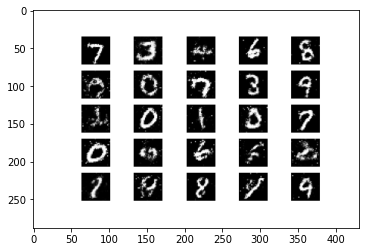

In [ ]:
a = imread('gan_images/10000.png')
plt.imshow(a)

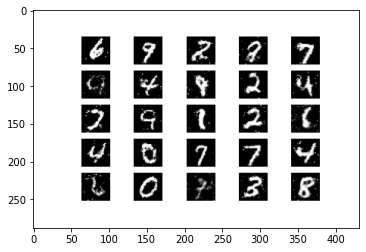

In [ ]:
a = imread('gan_images/20000.png')
plt.imshow(a)

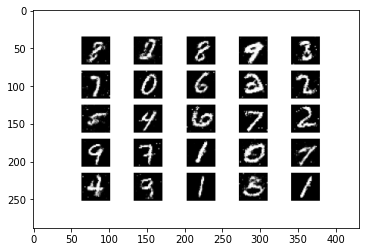

In [ ]:
a = imread('gan_images/29800.png')
plt.imshow(a)